In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from datetime import datetime
import numpy as np
from pytagi.hybrid import *

from src.RL_functions.generate_one_synthetic_time_series import generate_datetime_values
from pytagi.nn import LSTM, Linear, Sequential

from examples.data_loader import SyntheticTimeSeriesDataloader, TimeSeriesDataloader

### Datasets overview

In [2]:
# Load the real time series
time_series_path = './data/HQ/CASC_LGA007EFAPRG910_2024_07.mat'
real_data = sio.loadmat(time_series_path)
real_timestamps = real_data['values'][:, 1][0].T[0][540:]
real_obs = real_data['values'][:, 2][0].T[0][540:].tolist()
real_datetime = generate_datetime_values(start_datetime=datetime(2012, 1, 15, 12, 0, 0), num_values=len(real_obs), time_step_interval=7)
datasets_splits = [216, 268, -1]

# Load synthetic time series
syn_observation_save_path='data/CASC_LGA007EFAPRG910_2024_07/RLDS_y_observation_1000episodes_mixed.csv'
syn_datetime_save_path='data/CASC_LGA007EFAPRG910_2024_07/RLDS_y_datetime_1000episodes_mixed.csv'
# Remove the first row in pandas dataframe
syn_obs = pd.read_csv(syn_observation_save_path, skiprows=0, delimiter=",", header=None)
syn_datetime = generate_datetime_values(start_datetime=datetime(2016, 9, 11, 12, 0, 0), num_values=len(syn_obs), time_step_interval=7)

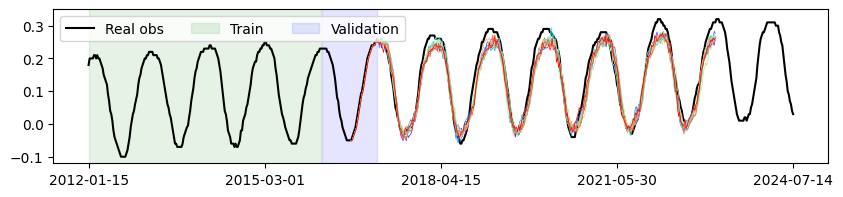

In [3]:
# Plot the real time series
fig = plt.figure(figsize=(10, 2))
plt.plot(real_datetime, real_obs, 'k', label='Real obs')
# Shaded the area between -0.2 and 0.4 for the x range until real_datetime[datasets_splits[0]]
plt.fill_between(real_datetime[:datasets_splits[0]], -0.2, 0.4, color='green', alpha=0.1, label='Train')
plt.fill_between(real_datetime[datasets_splits[0]:datasets_splits[1]], -0.2, 0.4, color='blue', alpha=0.1, label='Validation')

# COLORS = plt.cm.get_cmap('rainbow', 10)
COLORS = plt.colormaps['rainbow'].resampled(10)
for i in range(10):
    plt.plot(syn_datetime, syn_obs[i].tolist(), color = COLORS(i), linewidth=0.5)

plt.legend(loc='upper left', ncol=3)
plt.ylim(-0.12, 0.35)
plt.xticks([real_datetime[0], real_datetime[int(len(real_datetime)/4)], real_datetime[int(len(real_datetime)/2)], real_datetime[int(len(real_datetime)*3/4)], real_datetime[-1]])
plt.gca().set_xticklabels([str(real_datetime[0])[0:10], str(real_datetime[int(len(real_datetime)/4)])[0:10], str(real_datetime[int(len(real_datetime)/2)])[0:10], str(real_datetime[int(len(real_datetime)*3/4)])[0:10], str(real_datetime[-1])[0:10]]);

In [4]:
print(len(syn_datetime))

338


In [5]:
# Preliminary analysis of the synthetic time series
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1
time_covariates = ['week_of_year']

train_dtl = TimeSeriesDataloader(
                            x_file = 'data/CASC_LGA007EFAPRG910_2024_07/ytrain_obs.csv',
                            date_time_file = 'data/CASC_LGA007EFAPRG910_2024_07/ytrain_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            stride = seq_stride,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )


real_ts_dtl = TimeSeriesDataloader(
                            x_file = 'data/CASC_LGA007EFAPRG910_2024_07/y_all_obs.csv',
                            date_time_file = 'data/CASC_LGA007EFAPRG910_2024_07/y_all_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            x_mean=train_dtl.x_mean,
                            x_std=train_dtl.x_std,
                            stride = seq_stride,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )

### HSL probability check

In [6]:
# Time series SSM model
# # LSTM model for LSTM component
LSTM_path = './saved_param/CASC_LGA007EFAPRG910_2024_07/lstm_test1.pth' 
model_path = LSTM_path
net_test = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net_test.set_threads(8)
net_test.load(filename = model_path)

initial_z = np.array([-0.08309378, 0.00077297,0.02])
initial_Sz = np.array([1.00e-05, 1.00e-08, 2.25e-02])

phi_AR = 0.8185086442104763
Sigma_AR = 0.0010854901745454314
AR_var_stationary = Sigma_AR / (1 - phi_AR**2)

ts_model = LSTM_SSM(
                    neural_network = net_test,           # LSTM
                    baseline = 'LT + plain_AR',
                    use_BAR=False,
                    input_BAR=[],
                    zB  = initial_z,
                    SzB = initial_Sz,
                    phi_AR = phi_AR,
                    Sigma_AR = Sigma_AR,
                    Sigma_AA_ratio = None,
                    phi_AA = None,
                    use_auto_AR = False,
                )

syn_ts_dtl = SyntheticTimeSeriesDataloader(
                    x_file=syn_observation_save_path,
                    select_column=0,
                    date_time_file=syn_datetime_save_path,
                    add_anomaly = True,
                    anomaly_magnitude=0.0,
                    # anomaly_magnitude=np.random.uniform(-0.01, 0.01),
                    anomaly_start=len(syn_datetime)-input_seq_len-200,
                    x_mean=train_dtl.x_mean,
                    x_std=train_dtl.x_std,
                    output_col=output_col,
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    num_features=num_features,
                    stride=seq_stride,
                    time_covariates=time_covariates,
                )

In [7]:
# batch_iter = syn_ts_dtl.create_data_loader(batch_size=1, shuffle=False)
batch_iter = real_ts_dtl.create_data_loader(batch_size=1, shuffle=False)


mu_preds_lstm = []
var_preds_lstm = []
obs_norm = []

hidden_state_one_ts = {'mu': [], 'var': []}
prediction_one_ts = {'mu': [], 'var': []}

sigma_v = 1E-12
var_y = np.full((len(output_col),), sigma_v**2, dtype=np.float32)

ts_model.init_ssm_hs()

for i, (x, y) in enumerate(batch_iter):
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )
    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = ts_model(mu_x, var_x)
    # Backward
    z_update, Sz_update = ts_model.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)

    hidden_state_one_ts['mu'].append(z_update.flatten().tolist())
    hidden_state_one_ts['var'].append(Sz_update.tolist())
    prediction_one_ts['mu'].append(y_pred.item())
    prediction_one_ts['var'].append(Sy_pred.item())
    obs_norm.extend(y)

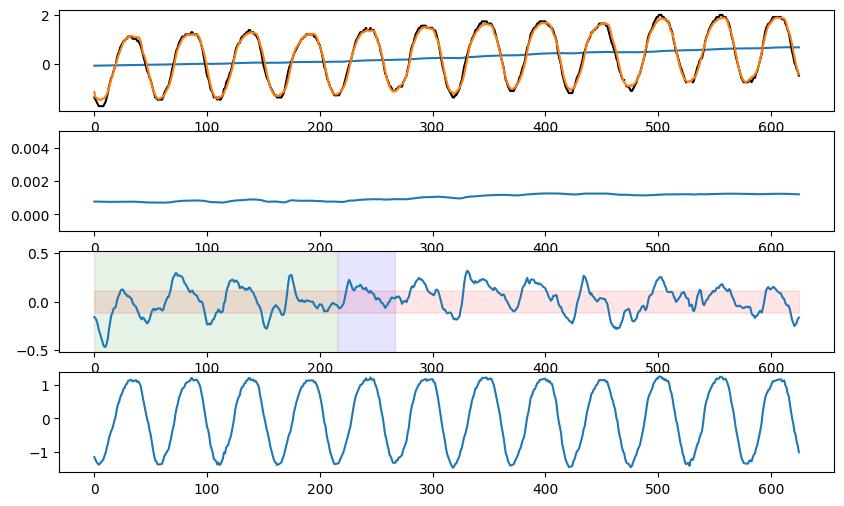

In [8]:
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

ax0.plot(np.transpose(hidden_state_one_ts['mu'])[0])
ax0.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[0]) - np.array(hidden_state_one_ts['var'])[:,0,0], np.array(np.transpose(hidden_state_one_ts['mu'])[0]) + np.array(hidden_state_one_ts['var'])[:,0,0], alpha=0.2)
ax0.plot(obs_norm, 'k')
ax0.plot(prediction_one_ts['mu'])
ax0.fill_between(range(len(obs_norm)), np.array(prediction_one_ts['mu']) - np.sqrt(np.array(prediction_one_ts['var'])), np.array(prediction_one_ts['mu']) + np.sqrt(np.array(prediction_one_ts['var'])), alpha=0.2)

ax1.plot(np.transpose(hidden_state_one_ts['mu'])[1])
ax1.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[1]) - np.array(hidden_state_one_ts['var'])[:,1,1], np.array(np.transpose(hidden_state_one_ts['mu'])[1]) + np.array(hidden_state_one_ts['var'])[:,1,1], alpha=0.2)
ax1.set_ylim(-0.001, 0.005)

ax2.plot(np.transpose(hidden_state_one_ts['mu'])[2])
ax2.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) - np.array(hidden_state_one_ts['var'])[:,2,2], np.array(np.transpose(hidden_state_one_ts['mu'])[2]) + np.array(hidden_state_one_ts['var'])[:,2,2], alpha=0.2)
ax2.fill_between(range(len(obs_norm)), np.zeros_like(len(obs_norm))-2*np.sqrt(AR_var_stationary), np.zeros_like(len(obs_norm))+2*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax2.fill_between(range(len(obs_norm))[:datasets_splits[0]], -1, 1, color='green', alpha=0.1, label='Train')
ax2.fill_between(range(len(obs_norm))[datasets_splits[0]:datasets_splits[1]], -1, 1, color='blue', alpha=0.1, label='Validation')
ax2.set_ylim(-0.52, 0.52)

ax3.plot(np.transpose(hidden_state_one_ts['mu'])[3])
ax3.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[3]) - np.array(hidden_state_one_ts['var'])[:,3,3], np.array(np.transpose(hidden_state_one_ts['mu'])[3]) + np.array(hidden_state_one_ts['var'])[:,3,3], alpha=0.2)